# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Curvature penalized models

In this notebook, we solve non-holonomic eikonal equations on the CPU and GPU, related to curvature penalized models.
Our purpose is to establish that the schemes produce consistent results.

In [1]:
large_instances = False

[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Constant cost](#1.-Constant-cost)
    * [1.1 Elastica](#1.1-Elastica)
    * [1.2 Reeds-Shepp](#1.2-Reeds-Shepp)
    * [1.3 ReedsShepp forward](#1.3-ReedsShepp-forward)
    * [1.4 Dubins](#1.4-Dubins)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research.
The author would like to acknowledge fruitful informal discussions with L. Gayraud on the 
topic of GPU coding and optimization.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Curvature_Repro','GPU'))

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

norm_infinity = ad.Optimization.norm_infinity
from agd.ExportedCode.Notebooks_GPU.Isotropic_Repro import RunCompare

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen,RunGPU,RunSmart,Metrics
    Eikonal,ad,cugen,Metrics = rreload([EIkonal,ad,cugen,Metrics],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

In [6]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

## 1. Constant cost

### 1.1 Elastica
The Euler elastica model is my favorite for the beauty of the curves it creates. However, it is also the hardest to accelerate on the GPU, due to the very wide stencils used.

In [7]:
n = 300 if large_instances else 100 
nTheta = 96 if large_instances else 64
hfmIn = Eikonal.dictIn({
    'model':'Elastica2',
    'seeds':cp.array([[0.,0.,np.pi]]),
    'exportValues':1,
    'cost':1,
    'xi':0.4,
    'count_updates':True,
#    'bound_active_blocks':True,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn.nTheta=nTheta
        
tips = hfmIn.Grid(dims=(4,4,4))
tips = np.moveaxis(tips.reshape(3,-1),0,-1)
hfmIn['tips'] = tips

In [8]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.02,check_ratio=0.01)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)


Preparing the GPU kernel


Running the eikonal GPU kernel


GPU kernel eikonal ran for 0.2469620704650879 seconds, and 89 iterations.
Post-Processing


--- gpu done, turning to cpu ---


Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 4.014 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.2469620704650879, CPU : 4.021. Device acceleration : 16.281852482154477
Max |gpuValues-cpuValues| :  1.5052871961650398


In [9]:
assert all(stop in ('AtSeed','PastSeed') for stop in gpuOut['geodesic_stopping_criteria'])

In [10]:
#np.sum(np.abs(gpuOut['values'].get()-cpuOut['values'])>0.02)/gpuOut['values'].size

The mean number of updates of any block.

In [11]:
np.mean(gpuOut['stats']['eikonal']['nupdate_o'])

array( 27.9)

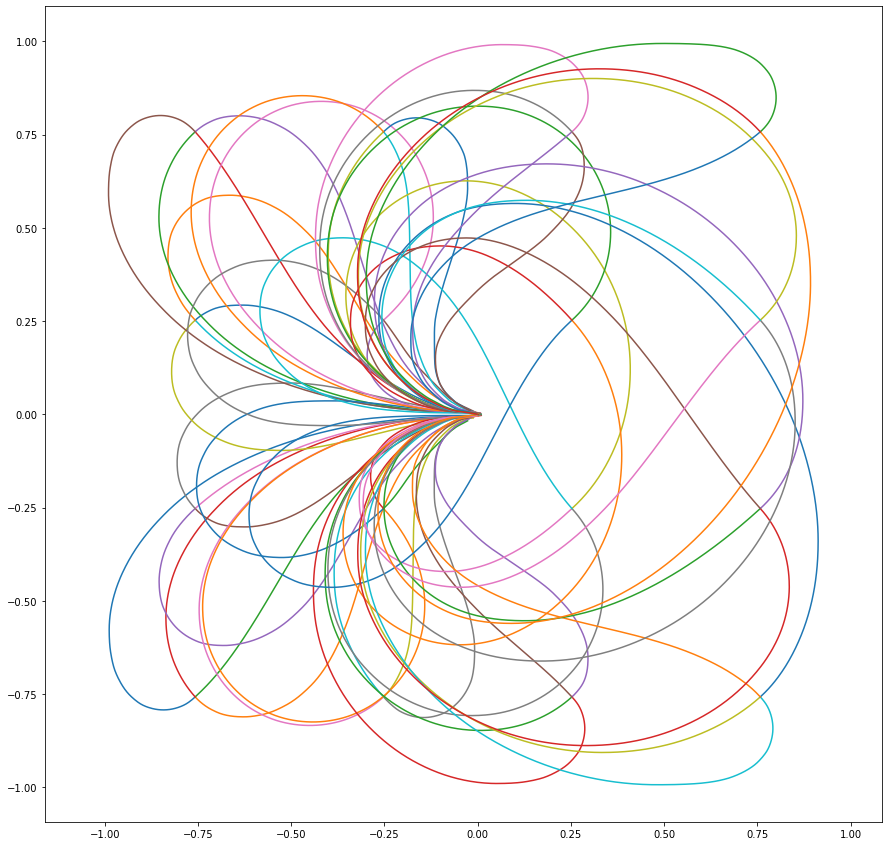

In [12]:
plt.figure(figsize=[15,15])
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(geo[0],geo[1])

### 1.2 Reeds-Shepp

In [13]:
hfmIn['model']='ReedsShepp2'
gpuOut,cpuOut = RunCompare(hfmIn,check=0.002,check_ratio=0.04) 

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel


Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0329747200012207 seconds, and 39 iterations.
Post-Processing
--- gpu done, turning to cpu ---

Field verbosity defaults to 1
Field eps defaults to 0.1
Field projective defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.114 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.0329747200012207, CPU : 1.12. Device acceleration : 33.965413503391034
Max |gpuValues-cpuValues| :  0.004388180303490197


In [14]:
assert all(stop=='AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])

The number of updates per block

In [15]:
np.mean(gpuOut['stats']['eikonal']['nupdate_o'])

array( 9.43)

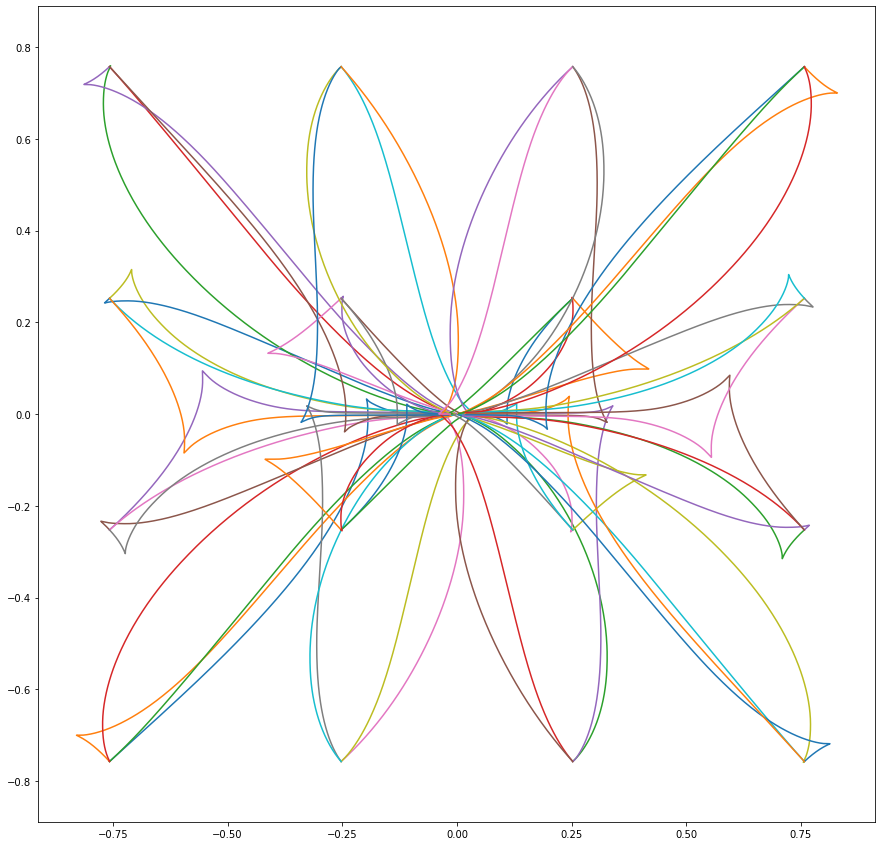

In [16]:
plt.figure(figsize=[15,15])
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(geo[0],geo[1])

### 1.3 ReedsShepp forward

In [17]:
hfmIn['model']='ReedsSheppForward2'
gpuOut,cpuOut = RunCompare(hfmIn,check=0.005,check_ratio=0.004) 

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel


Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.04247689247131348 seconds, and 45 iterations.
Post-Processing
--- gpu done, turning to cpu ---

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.54 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.04247689247131348, CPU : 0.546. Device acceleration : 12.854047653526868
Max |gpuValues-cpuValues| :  0.21157774249867334


In [18]:
np.mean(gpuOut['stats']['eikonal']['nupdate_o'])

array( 9.39)

In [19]:
# Stationnary deserves investigation...
assert all(stop in ('AtSeed','PastSeed','Stationnary') for stop in gpuOut['geodesic_stopping_criteria'])

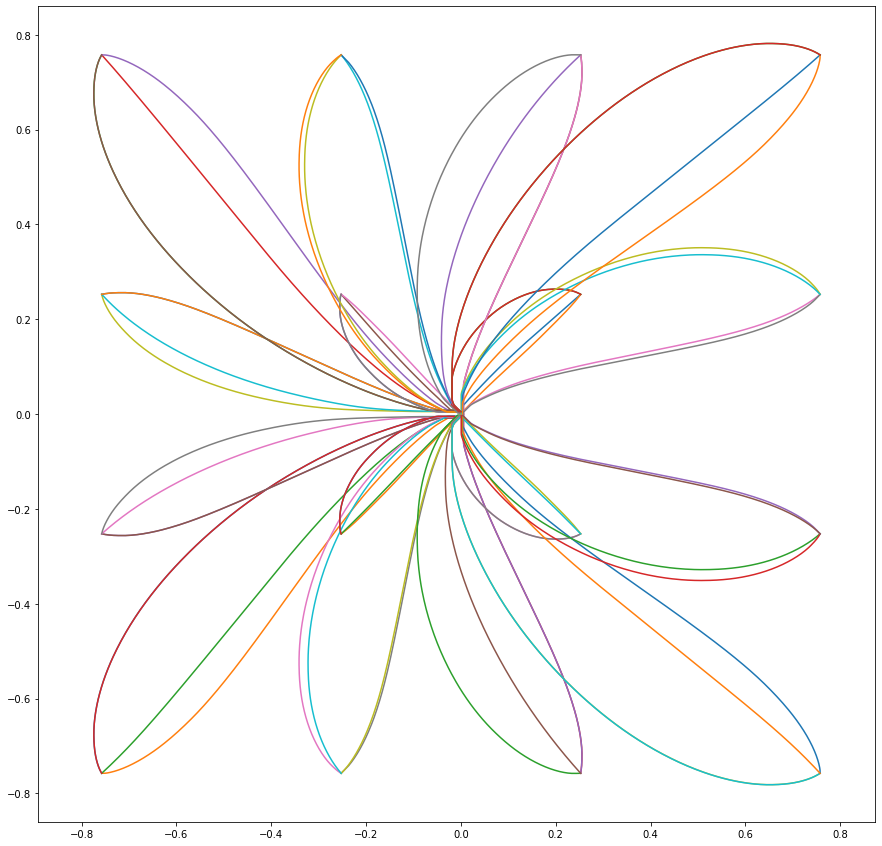

In [20]:
plt.figure(figsize=[15,15])
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(geo[0],geo[1])

### 1.4 Dubins

In [21]:
hfmIn['model']='Dubins2'
gpuOut,cpuOut = RunCompare(hfmIn,check=0.005,check_ratio=0.02) #check=0.005,check_ratio=0.004) 

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel


Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0644991397857666 seconds, and 101 iterations.
Post-Processing


--- gpu done, turning to cpu ---


Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.82 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.0644991397857666, CPU : 1.826. Device acceleration : 28.310455086146032
Max |gpuValues-cpuValues| :  0.0531112294427909


Some points of the domain are not reached by the front propagation, due to the non-locally controllable nature of the model.
No geodesic can be extracted from these points, and the stopping criterion is set to 'InWall'.

In [22]:
assert all(stop in ('AtSeed','PastSeed','InWall') for stop in gpuOut['geodesic_stopping_criteria'])

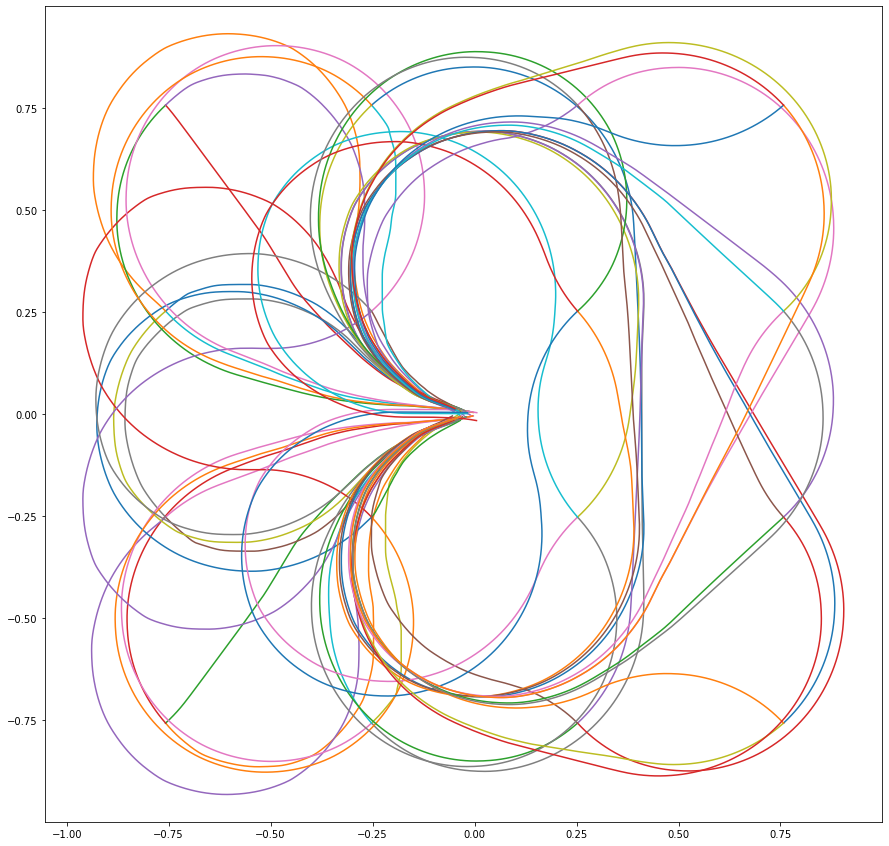

In [23]:
plt.figure(figsize=[15,15])
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(geo[0],geo[1])